d:\Anaconda\envs\torchgpu\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-08-15 15:00:50,303] A new study created in memory with name: no-name-f635e5c0-566c-47cf-9564-8335352944a8


Using device: cuda


[I 2025-08-15 15:00:56,388] Trial 5 finished with value: 0.0827498328105894 and parameters: {'lookback': 24, 'num_layers': 1, 'hidden_size': 16, 'lr': 0.0013936504254208602, 'batch_size': 32}. Best is trial 5 with value: 0.0827498328105894.
[I 2025-08-15 15:00:56,462] Trial 2 finished with value: 0.08068713736017451 and parameters: {'lookback': 3, 'num_layers': 2, 'hidden_size': 114, 'lr': 0.0008304409228607597, 'batch_size': 32}. Best is trial 2 with value: 0.08068713736017451.
[I 2025-08-15 15:00:57,325] Trial 4 finished with value: 0.08083386608901638 and parameters: {'lookback': 21, 'num_layers': 2, 'hidden_size': 103, 'lr': 0.0011300430015691253, 'batch_size': 64}. Best is trial 2 with value: 0.08068713736017451.
[I 2025-08-15 15:00:57,385] Trial 12 finished with value: 0.08345193749248517 and parameters: {'lookback': 12, 'num_layers': 3, 'hidden_size': 44, 'lr': 0.005757096134804505, 'batch_size': 64}. Best is trial 2 with value: 0.08068713736017451.
[I 2025-08-15 15:00:58,014] T

Best hyperparameters: {'lookback': 1, 'num_layers': 1, 'hidden_size': 29, 'lr': 0.002674514933531211, 'batch_size': 32}
Best validation RMSE: 0.07838638942224427
Rolling Forecast Test Metrics: {
  "MSE": 227.90254562573534,
  "RMSE": 15.09644148883224,
  "MAE": 13.936253214384381,
  "MAPE%": 22.096085370762296,
  "R2": -5.505317886475545
}


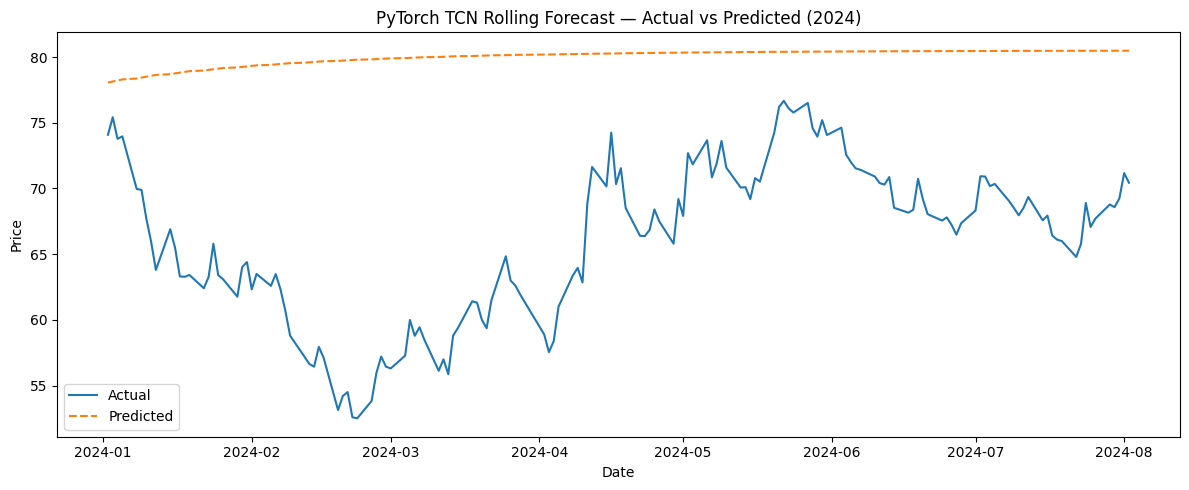

In [1]:
"""
Carbon Price Forecasting with PyTorch TCN
- Hyperparameters tuned via Optuna: lookback, n_layers, hidden_size, learning_rate, batch_size
- Uses a TCN architecture with dilated causal convolutions.
- Proper scaling (train-only during tuning; train+val for final model)
- Time split: Train=2021-01-01..2023-12-31 (last 10% of that for val); Test=2024-01-01..2024-12-31
- Rolling (recursive) forecast on the 2024 test set

Requirements: pip install optuna torch scikit-learn matplotlib pandas
"""

import os
import math
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import optuna

# -------------------- Config --------------------
RANDOM_STATE = 42
CSV_PATH = "Carbon_Emissions_Futures_2021_Onwards.csv"  # <--- change if needed
DATE_COL = "Date"
TARGET_COL = "Price"

# Reproducibility
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

# -------------------- Data utils --------------------
def _parse_volume(v):
    if pd.isna(v):
        return np.nan
    if isinstance(v, (int, float)):
        return float(v)
    s = str(v).strip().replace(",", "")
    if s.endswith(("K","k")):
        return float(s[:-1]) * 1_000
    if s.endswith(("M","m")):
        return float(s[:-1]) * 1_000_000
    return float(s)


def clean_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.rename(columns={"Vol.": "Volume", "Change %": "ChangePct"}, inplace=True)
    df[DATE_COL] = pd.to_datetime(df[DATE_COL], dayfirst=True, errors='coerce')
    for col in ["Price", "Open", "High", "Low"]:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    if "Volume" in df:
        df["Volume"] = df["Volume"].apply(_parse_volume)
    if "ChangePct" in df:
        df["ChangePct"] = pd.to_numeric(df["ChangePct"].astype(str).str.replace('%',''), errors='coerce') / 100.0
    df = df.dropna(subset=[DATE_COL]).sort_values(DATE_COL).reset_index(drop=True)
    return df


def train_val_test_split(df: pd.DataFrame):
    train_mask = (df[DATE_COL] >= '2021-01-01') & (df[DATE_COL] <= '2023-12-31')
    test_mask  = (df[DATE_COL] >= '2024-01-01') & (df[DATE_COL] <= '2024-12-31')
    df_train_full = df.loc[train_mask].copy()
    df_test = df.loc[test_mask].copy()
    split_idx = int(len(df_train_full) * 0.9)
    return df_train_full.iloc[:split_idx], df_train_full.iloc[split_idx:], df_test


def create_sequences(series_2d: np.ndarray, lookback: int):
    """series_2d shape: (N, 1). Returns X: (N-lookback, lookback, 1), y: (N-lookback,).
    """
    X, y = [], []
    for i in range(lookback, len(series_2d)):
        X.append(series_2d[i-lookback:i])
        y.append(series_2d[i, 0])
    return np.asarray(X, dtype=np.float32), np.asarray(y, dtype=np.float32)


class SeqDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# -------------------- Model (TCN) --------------------
class CausalConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation, **kwargs):
        super(CausalConv1d, self).__init__()
        self.padding = (kernel_size - 1) * dilation
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=self.padding, dilation=dilation, **kwargs)

    def forward(self, x):
        x = self.conv(x)
        return x[:, :, :-self.padding]


class TCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation_factor):
        super(TCNBlock, self).__init__()
        self.conv1 = CausalConv1d(in_channels, out_channels, kernel_size, dilation=dilation_factor)
        self.relu1 = nn.ReLU()
        self.conv2 = CausalConv1d(out_channels, out_channels, kernel_size, dilation=dilation_factor)
        self.relu2 = nn.ReLU()

        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None

    def forward(self, x):
        residual = x
        if self.downsample is not None:
            residual = self.downsample(residual)

        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        return out + residual


class TCNRegressor(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int, kernel_size: int = 2):
        super().__init__()
        layers = []
        in_channels = input_size
        for i in range(num_layers):
            dilation_factor = 2 ** i
            out_channels = hidden_size
            layers.append(TCNBlock(in_channels, out_channels, kernel_size, dilation_factor))
            in_channels = out_channels
        self.tcn = nn.Sequential(*layers)
        self.head = nn.Linear(in_channels, 1)

    def forward(self, x):  # x: (B, T, F)
        # Permute to (B, F, T) for Conv1D
        x = x.permute(0, 2, 1)
        out = self.tcn(x)
        last_out = out[:, :, -1] # Output from the last time step
        return self.head(last_out).squeeze(-1)


# -------------------- Metrics --------------------
def evaluate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-8, None))) * 100
    r2 = r2_score(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "MAPE%": mape, "R2": r2}


# -------------------- Training loop --------------------
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total = 0.0
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total += loss.item() * xb.size(0)
    return total / len(loader.dataset)


def eval_epoch(model, loader, criterion, device):
    model.eval()
    total = 0.0
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            total += loss.item() * xb.size(0)
    return total / len(loader.dataset)


# -------------------- Main --------------------
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # 1) Load & clean
    raw = pd.read_csv(CSV_PATH)
    df = clean_dataframe(raw)

    # 2) Split
    df_train, df_val, df_test = train_val_test_split(df)

    # 3) Scale (train-only for tuning)
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(df_train[[TARGET_COL]])
    val_scaled   = scaler.transform(df_val[[TARGET_COL]])

    # -------- Optuna objective --------
    def objective(trial: optuna.Trial):
        lookback   = trial.suggest_int("lookback", 1, 30)
        num_layers = trial.suggest_int("num_layers", 1, 3)
        hidden_sz  = trial.suggest_int("hidden_size", 16, 128, log=True)
        lr         = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
        batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
        epochs     = 100

        Xtr, ytr = create_sequences(train_scaled, lookback)
        Xval_in = np.vstack([train_scaled[-lookback:], val_scaled])
        yval_in = np.concatenate([train_scaled[-lookback:,0], val_scaled[:,0]])
        Xva, yva = create_sequences(Xval_in, lookback)

        train_ds = SeqDataset(Xtr, ytr)
        val_ds   = SeqDataset(Xva, yva)
        train_ld = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        val_ld   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

        model = TCNRegressor(input_size=1, hidden_size=hidden_sz, num_layers=num_layers).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = nn.MSELoss()

        best_val = float('inf')
        patience, wait = 5, 0

        for epoch in range(epochs):
            train_epoch(model, train_ld, criterion, optimizer, device)
            val_loss = eval_epoch(model, val_ld, criterion, device)
            if val_loss < best_val - 1e-6:
                best_val = val_loss
                wait = 0
            else:
                wait += 1
                if wait >= patience:
                    break
        return math.sqrt(best_val)

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=200, n_jobs=-1)

    print("Best hyperparameters:", study.best_params)
    print("Best validation RMSE:", study.best_value)

    best = study.best_params
    lookback   = best["lookback"]
    num_layers = best["num_layers"]
    hidden_sz  = best["hidden_size"]
    lr         = best["lr"]
    batch_size = best["batch_size"]

    full_scaler = StandardScaler()
    trainval_scaled = full_scaler.fit_transform(pd.concat([df_train, df_val])[ [TARGET_COL] ])

    Xtrv, ytrv = create_sequences(trainval_scaled, lookback)
    trainval_ds = SeqDataset(Xtrv, ytrv)
    trainval_ld = DataLoader(trainval_ds, batch_size=batch_size, shuffle=True)

    model_final = TCNRegressor(input_size=1, hidden_size=hidden_sz, num_layers=num_layers).to(device)
    optimizer   = torch.optim.Adam(model_final.parameters(), lr=lr)
    criterion   = nn.MSELoss()

    EPOCHS_FINAL = 50
    for _ in range(EPOCHS_FINAL):
        train_epoch(model_final, trainval_ld, criterion, optimizer, device)

    history = trainval_scaled.tolist()
    preds_scaled = []
    with torch.no_grad():
        for _ in range(len(df_test)):
            x_in = np.array(history[-lookback:]).reshape(1, lookback, 1).astype(np.float32)
            x_tensor = torch.from_numpy(x_in).to(device)
            yhat = model_final(x_tensor).cpu().numpy().ravel()[0]
            preds_scaled.append(yhat)
            history.append([yhat])

    preds = full_scaler.inverse_transform(np.array(preds_scaled).reshape(-1,1)).ravel()

    y_test = df_test[TARGET_COL].values
    metrics = evaluate_metrics(y_test, preds)
    print("Rolling Forecast Test Metrics:", json.dumps(metrics, indent=2))

    plt.figure(figsize=(12,5))
    plt.plot(df_test[DATE_COL], y_test, label='Actual')
    plt.plot(df_test[DATE_COL], preds, label='Predicted', linestyle='--')
    plt.title('PyTorch TCN Rolling Forecast — Actual vs Predicted (2024)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # with open('best_tcn_params.json', 'w') as f:
    #     json.dump({"best_params": study.best_params, "best_val_rmse": study.best_value}, f, indent=2)
    # print("Saved best params to best_tcn_params.json")

[I 2025-08-15 19:20:52,171] A new study created in memory with name: no-name-9ffe9950-a02c-4981-b072-774c75bffb6f


Using device: cuda


[I 2025-08-15 19:20:56,657] Trial 0 finished with value: 0.11980608480710733 and parameters: {'lookback': 9, 'num_layers': 1, 'hidden_size': 38, 'lr': 0.00023175554591689003, 'batch_size': 16, 'kernel_size': 5}. Best is trial 0 with value: 0.11980608480710733.
[I 2025-08-15 19:20:58,487] Trial 1 finished with value: 0.0846817205007895 and parameters: {'lookback': 15, 'num_layers': 2, 'hidden_size': 118, 'lr': 0.00014135268578584258, 'batch_size': 64, 'kernel_size': 7}. Best is trial 1 with value: 0.0846817205007895.
[I 2025-08-15 19:21:00,280] Trial 2 finished with value: 0.08269247179729136 and parameters: {'lookback': 16, 'num_layers': 3, 'hidden_size': 103, 'lr': 0.005165087663684193, 'batch_size': 64, 'kernel_size': 7}. Best is trial 2 with value: 0.08269247179729136.
[I 2025-08-15 19:21:02,484] Trial 3 finished with value: 0.0851649141424495 and parameters: {'lookback': 6, 'num_layers': 1, 'hidden_size': 66, 'lr': 0.00020417647062484525, 'batch_size': 64, 'kernel_size': 2}. Best i

Best hyperparameters: {'lookback': 6, 'num_layers': 3, 'hidden_size': 114, 'lr': 0.00655977443758404, 'batch_size': 32, 'kernel_size': 6}
Best validation RMSE: 0.07786201549263512
Multi-step Rolling Forecast (1-day blocks) Test Metrics: {
  "MSE": 3.502976097321474,
  "RMSE": 1.8716239198411293,
  "MAE": 1.5200920978345378,
  "MAPE%": 2.3251619011006808,
  "R2": 0.9000100108612898
}
Saved plot to tcn_pytorch_multistep_forecast_2024_1steps.png
Saved best params to best_tcn_params_multistep_1steps.json


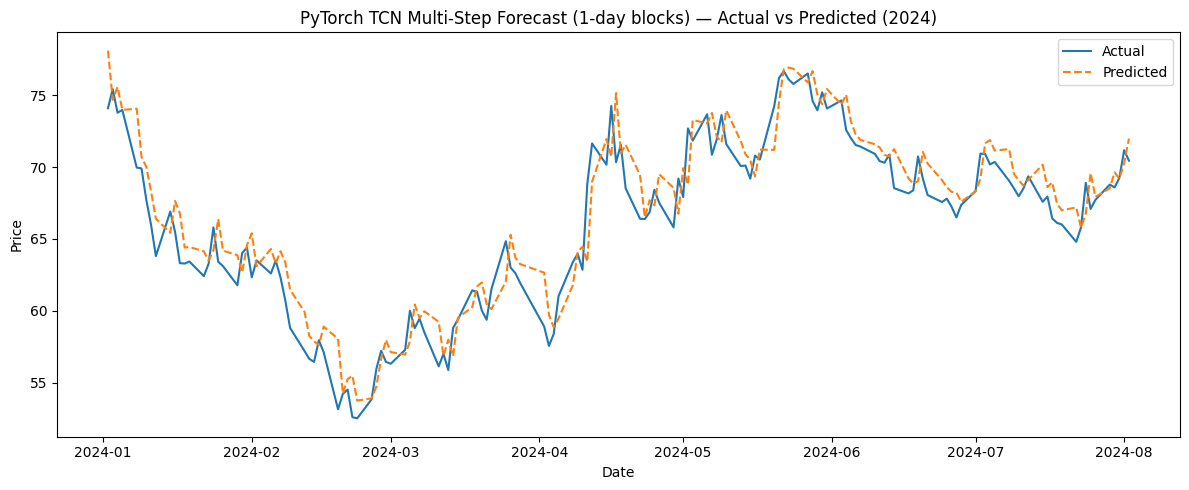

In [6]:
"""
Modified: Carbon Price Forecasting with PyTorch TCN
- Multi-step Rolling Forecast with user-defined steps.
- The model predicts a block of days at a time, then uses ground truth to advance the window.
"""

import os
import math
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import optuna

# -------------------- Config --------------------
RANDOM_STATE = 42
CSV_PATH = "Carbon_Emissions_Futures_2021_Onwards.csv"
DATE_COL = "Date"
TARGET_COL = "Price"
FORECAST_STEPS = 1  # <--- USER INPUT: Number of steps to forecast ahead in a block

# Reproducibility
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

# -------------------- Data utils --------------------
def _parse_volume(v):
    if pd.isna(v):
        return np.nan
    if isinstance(v, (int, float)):
        return float(v)
    s = str(v).strip().replace(",", "")
    if s.endswith(("K","k")):
        return float(s[:-1]) * 1_000
    if s.endswith(("M","m")):
        return float(s[:-1]) * 1_000_000
    return float(s)

def clean_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.rename(columns={"Vol.": "Volume", "Change %": "ChangePct"}, inplace=True)
    df[DATE_COL] = pd.to_datetime(df[DATE_COL], dayfirst=True, errors='coerce')
    for col in ["Price", "Open", "High", "Low"]:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    if "Volume" in df:
        df["Volume"] = df["Volume"].apply(_parse_volume)
    if "ChangePct" in df:
        df["ChangePct"] = pd.to_numeric(df["ChangePct"].astype(str).str.replace('%',''), errors='coerce') / 100.0
    df = df.dropna(subset=[DATE_COL]).sort_values(DATE_COL).reset_index(drop=True)
    return df

def train_val_test_split(df: pd.DataFrame):
    train_mask = (df[DATE_COL] >= '2021-01-01') & (df[DATE_COL] <= '2023-12-31')
    test_mask  = (df[DATE_COL] >= '2024-01-01') & (df[DATE_COL] <= '2024-12-31')
    df_train_full = df.loc[train_mask].copy()
    df_test = df.loc[test_mask].copy()
    split_idx = int(len(df_train_full) * 0.9)
    return df_train_full.iloc[:split_idx], df_train_full.iloc[split_idx:], df_test

def create_sequences(series_2d: np.ndarray, lookback: int):
    X, y = [], []
    for i in range(lookback, len(series_2d)):
        X.append(series_2d[i-lookback:i])
        y.append(series_2d[i, 0])
    return np.asarray(X, dtype=np.float32), np.asarray(y, dtype=np.float32)

class SeqDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# -------------------- Model (TCN) --------------------
class CausalConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation, **kwargs):
        super(CausalConv1d, self).__init__()
        self.padding = (kernel_size - 1) * dilation
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=self.padding, dilation=dilation, **kwargs)
    def forward(self, x):
        x = self.conv(x)
        return x[:, :, :-self.padding]

class TCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation_factor):
        super(TCNBlock, self).__init__()
        self.conv1 = CausalConv1d(in_channels, out_channels, kernel_size, dilation=dilation_factor)
        self.relu1 = nn.ReLU()
        self.conv2 = CausalConv1d(out_channels, out_channels, kernel_size, dilation=dilation_factor)
        self.relu2 = nn.ReLU()
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
    def forward(self, x):
        residual = x
        if self.downsample is not None:
            residual = self.downsample(residual)
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        return out + residual

class TCNRegressor(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int, kernel_size: int):
        super().__init__()
        layers = []
        in_channels = input_size
        for i in range(num_layers):
            dilation_factor = 2 ** i
            out_channels = hidden_size
            layers.append(TCNBlock(in_channels, out_channels, kernel_size, dilation_factor))
            in_channels = out_channels
        self.tcn = nn.Sequential(*layers)
        self.head = nn.Linear(in_channels, 1)
    def forward(self, x):
        x = x.permute(0, 2, 1)
        out = self.tcn(x)
        last_out = out[:, :, -1]
        return self.head(last_out).squeeze(-1)

# -------------------- Metrics --------------------
def evaluate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-8, None))) * 100
    r2 = r2_score(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "MAPE%": mape, "R2": r2}

# -------------------- Training loop --------------------
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total = 0.0
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total += loss.item() * xb.size(0)
    return total / len(loader.dataset)

def eval_epoch(model, loader, criterion, device):
    model.eval()
    total = 0.0
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            total += loss.item() * xb.size(0)
    return total / len(loader.dataset)

# -------------------- Main --------------------
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    raw = pd.read_csv(CSV_PATH)
    df = clean_dataframe(raw)
    df_train, df_val, df_test = train_val_test_split(df)
    
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(df_train[[TARGET_COL]])
    val_scaled   = scaler.transform(df_val[[TARGET_COL]])

    def objective(trial: optuna.Trial):
        lookback   = trial.suggest_int("lookback", 2, 30)
        num_layers = trial.suggest_int("num_layers", 1, 3)
        hidden_sz  = trial.suggest_int("hidden_size", 16, 128, log=True)
        lr         = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
        batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
        kernel_size = trial.suggest_int("kernel_size", 2, 7)
        epochs     = 100

        Xtr, ytr = create_sequences(train_scaled, lookback)
        Xval_in = np.vstack([train_scaled[-lookback:], val_scaled])
        yval_in = np.concatenate([train_scaled[-lookback:,0], val_scaled[:,0]])
        Xva, yva = create_sequences(Xval_in, lookback)

        train_ds = SeqDataset(Xtr, ytr)
        val_ds   = SeqDataset(Xva, yva)
        train_ld = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        val_ld   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

        model = TCNRegressor(input_size=1, hidden_size=hidden_sz, num_layers=num_layers, kernel_size=kernel_size).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = nn.MSELoss()

        best_val = float('inf')
        patience, wait = 5, 0
        for epoch in range(epochs):
            train_epoch(model, train_ld, criterion, optimizer, device)
            val_loss = eval_epoch(model, val_ld, criterion, device)
            if val_loss < best_val - 1e-6:
                best_val = val_loss
                wait = 0
            else:
                wait += 1
                if wait >= patience:
                    break
        return math.sqrt(best_val)

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=200)

    print("Best hyperparameters:", study.best_params)
    print("Best validation RMSE:", study.best_value)

    best = study.best_params
    lookback   = best["lookback"]
    num_layers = best["num_layers"]
    hidden_sz  = best["hidden_size"]
    lr         = best["lr"]
    batch_size = best["batch_size"]
    kernel_size = best["kernel_size"]

    full_scaler = StandardScaler()
    trainval_scaled = full_scaler.fit_transform(pd.concat([df_train, df_val])[ [TARGET_COL] ])
    Xtrv, ytrv = create_sequences(trainval_scaled, lookback)
    trainval_ds = SeqDataset(Xtrv, ytrv)
    trainval_ld = DataLoader(trainval_ds, batch_size=batch_size, shuffle=True)
    model_final = TCNRegressor(input_size=1, hidden_size=hidden_sz, num_layers=num_layers, kernel_size=kernel_size).to(device)
    optimizer   = torch.optim.Adam(model_final.parameters(), lr=lr)
    criterion   = nn.MSELoss()

    EPOCHS_FINAL = 50
    for _ in range(EPOCHS_FINAL):
        train_epoch(model_final, trainval_ld, criterion, optimizer, device)

    # -------------------- Multi-step rolling forecast loop (MODIFIED) --------------------
    history = trainval_scaled.tolist()
    preds_scaled = []
    y_test_scaled = full_scaler.transform(df_test[[TARGET_COL]]).tolist()

    with torch.no_grad():
        for i in range(0, len(df_test), FORECAST_STEPS):
            # A) Make multi-step predictions based on current history
            temp_history = history.copy()
            block_preds = []
            for _ in range(FORECAST_STEPS):
                x_in = np.array(temp_history[-lookback:]).reshape(1, lookback, 1).astype(np.float32)
                x_tensor = torch.from_numpy(x_in).to(device)
                yhat = model_final(x_tensor).cpu().numpy().ravel()[0]
                block_preds.append(yhat)
                temp_history.append([yhat]) # Use prediction for the next step within the block
            
            preds_scaled.extend(block_preds)

            # B) Advance the window using ground truth
            for j in range(FORECAST_STEPS):
                if i + j < len(df_test):
                    history.append(y_test_scaled[i + j])
                else:
                    break
    
    preds_scaled = preds_scaled[:len(df_test)]

    preds = full_scaler.inverse_transform(np.array(preds_scaled).reshape(-1,1)).ravel()

    # -------------------- Metrics & Plot --------------------
    y_test = df_test[TARGET_COL].values
    metrics = evaluate_metrics(y_test, preds)
    print(f"Multi-step Rolling Forecast ({FORECAST_STEPS}-day blocks) Test Metrics:", json.dumps(metrics, indent=2))

    plt.figure(figsize=(12,5))
    plt.plot(df_test[DATE_COL], y_test, label='Actual')
    plt.plot(df_test[DATE_COL], preds, label='Predicted', linestyle='--')
    plt.title(f'PyTorch TCN Multi-Step Forecast ({FORECAST_STEPS}-day blocks) — Actual vs Predicted (2024)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'tcn_pytorch_multistep_forecast_2024_{FORECAST_STEPS}steps.png', dpi=150)
    print(f"Saved plot to tcn_pytorch_multistep_forecast_2024_{FORECAST_STEPS}steps.png")

    with open(f'best_tcn_params_multistep_{FORECAST_STEPS}steps.json', 'w') as f:
        json.dump({"best_params": study.best_params, "best_val_rmse": study.best_value}, f, indent=2)
    print(f"Saved best params to best_tcn_params_multistep_{FORECAST_STEPS}steps.json")